successfully loaded 17166 entries
Calculating Metropolis-Hastings random walk...


/Users/wchen/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:207: RuntimeWarning: overflow encountered in exp
/Users/wchen/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: overflow encountered in exp


iter: 500
iter: 1000
iter: 1500
iter: 2000
iter: 2500
iter: 3000
iter: 3500
iter: 4000
iter: 4500
iter: 5000
iter: 5500
iter: 6000
iter: 6500
iter: 7000
iter: 7500
iter: 8000
iter: 8500
iter: 9000
iter: 9500
iter: 10000
writing model parameters to file...


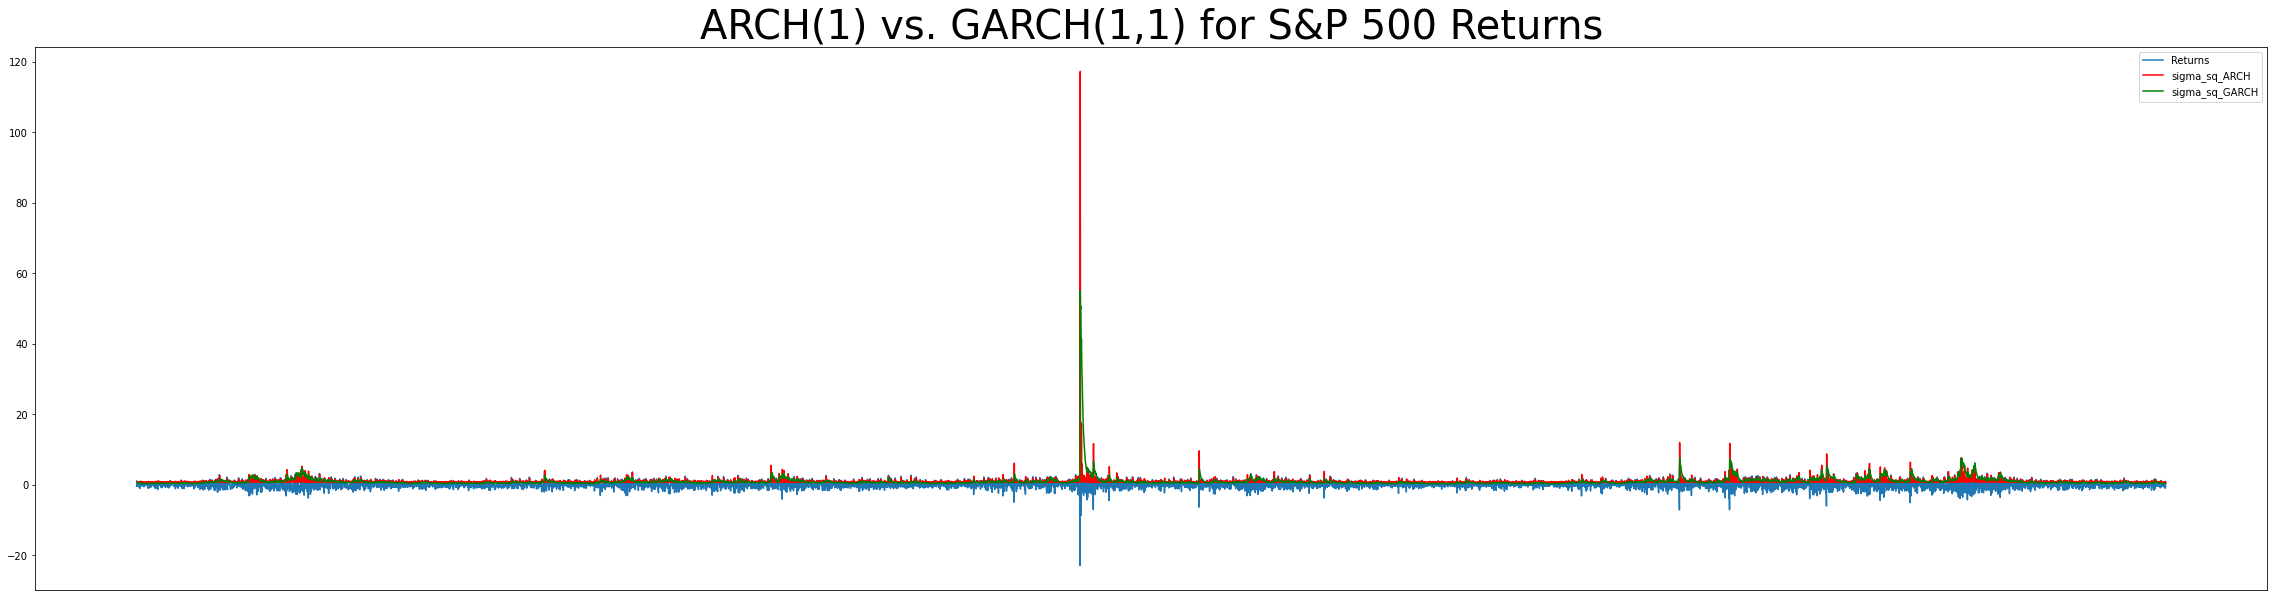

Calculating log-scores for model-comparison


/Users/wchen/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:207: RuntimeWarning: overflow encountered in exp
/Users/wchen/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: overflow encountered in exp


iter: 500
iter: 1000
iter: 1500
iter: 2000
iter: 2500
iter: 3000
iter: 3500
iter: 4000
iter: 4500
iter: 5000
iter: 5500
iter: 6000
iter: 6500
iter: 7000
iter: 7500
iter: 8000
iter: 8500
iter: 9000
iter: 9500
iter: 10000
writing model parameters to file...
performing predictive log-score comparisons...
ARCH predictive log-score on test data: -396.6784834570662
GARCH predictive log-score on test data: -465.00760728987825


In [16]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

NUM_ITERS = 10000
BURN_IN = 400

LOAD = False
LOAD_PRED = False

HIGH_ACCEPT_THRESHOLD = 0.8
LOW_ACCEPT_THRESHOLD = 0.2

SIGMA_PATH = "../data/sigma_sq_10k_ARCH.txt"
OMEGA_PATH = "../data/omega_ARCH.txt"
ALPHA_PATH = "../data/alpha_ARCH.txt"

SIGMA_PATH_PRED = "../data/sigma_sq_10k_ARCH_85%.txt"
OMEGA_PATH_PRED = "../data/omega_ARCH_85%.txt"
ALPHA_PATH_PRED = "../data/alpha_ARCH_85%.txt"


class MetropolisHastingsARCH:
    
    def __init__(self, num_iters, burn_in, returns):
        self.NUM_ITERS = num_iters # simulation iterations post-burn-in
        self.BURN_IN = burn_in # burn-in iterations 
        self.TOTAL_SIM_ITERS = self.NUM_ITERS + self.BURN_IN # total simulation iterations
        self.PROG_LOG_STEP = 100 # how often to log progress
        
        # set returns
        self.returns = returns
        
        # simulation value arrays
        self.sim_omega = np.zeros(self.TOTAL_SIM_ITERS)
        self.sim_alpha = np.zeros(self.TOTAL_SIM_ITERS)
        
        self.avg_sigma_sq = np.zeros(len(returns))
        
        self.finished = False
        
        
    '''
    Get parameters
    '''
    def get_param_results(self):
        if not self.finished:
             raise Exception("need to run random walk before getting param results")
            
        return self.sim_omega, self.sim_alpha
        
    '''
    Only call after calling random walk, get sigma_sq array
    '''
    def get_sigma_sq_results(self):
        if not self.finished:
            raise Exception("need to run random walk before getting results")
            
        return self.avg_sigma_sq
    
    '''
    Only call after calling random walk, write params to filepaths
    '''
    def write_params_to_file(self, predictive):
        if not self.finished:
            raise Exception("need to run random walk before writing to files")
        
        print("writing model parameters to file...")
        
        if (predictive):
            np.savetxt(SIGMA_PATH_PRED, self.avg_sigma_sq)
            np.savetxt(OMEGA_PATH_PRED, self.sim_omega)
            np.savetxt(ALPHA_PATH_PRED, self.sim_alpha)
        else:
            np.savetxt(SIGMA_PATH, self.avg_sigma_sq)
            np.savetxt(OMEGA_PATH, self.sim_omega)
            np.savetxt(ALPHA_PATH, self.sim_alpha)

        
    '''
    Prior(omega) follows an inverse gamma distribution. Choose hyperparameters 
    '''
    def log_omega_prior(self, omega, g_alpha, g_beta):
        # can look up the density ? if want to?
        g = stats.invgamma.pdf(omega, g_alpha, scale=g_beta)
        if g < 0:
            raise Exception("NEGATIVE IN LOG PRIOR OMEGA")
        return np.log(g)
    
    '''
    Prior(alpha, beta), uniform improper prior proportional to 1{alpha>0, beta>0, alpha+beta < 1}
    CONSTANT, IS NOT USED IN ACCPETANCE PROBABILITY SINCE IT CANCELS OUT
    '''
    def log_alpha_beta_prior(self):
        return 0.0
    
    
    '''
    Returns the variance expression of a GARCH(1,1) process.
    '''
    def garch_filter(self, omega, alpha):
               
        # Length of log_returns
        length = len(self.returns)
        
        # Initializing an empty array
        sigma_sq = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_sq[i] = omega / (1 - alpha)
            else:
                sigma_sq[i] = omega + (alpha * (self.returns[i-1]**2))
                
        return sigma_sq
        
        
    '''
    Likelihood function, is this good?
    '''
    def log_likelihood(self, omega, alpha):
        
        sigma_sq = self.garch_filter(omega, alpha)
        
        log_term = 2*np.pi*sigma_sq
        
        if np.min(log_term) < 0:
            raise Exception("NEGATIVE INNER TERM IN LOG LIKELIHOOD")
        
        log_likelihood = -0.5 * np.sum(np.log(log_term) + (self.returns**2)/sigma_sq)
        
        return log_likelihood
    

    '''
    Metropolis-Hastings random walk
    '''
    def random_walk_arch(self):
    
        # parameters for priors 
        # choose based on expected mean for omega, variance not too small, LOOK AT INV GAMMA STUFF
        g_a_prior = 3.0
        g_b_prior = 2.0
        
        # start with some arbitrary var for proposals 
        var_covar_prop = np.zeros((2, 2))
        var_covar_prop[0, 0] = 0.75 # omega variance
        var_covar_prop[1, 1] = 0.5 # alpha variance
        
        # want acceptance in between 0.2 and 0.8
        # need to adjust proposal std 
        omega_acc_count = 0
        ab_acc_count = 0
        
        
        # initialize simulation chain in a sensible way (what's a sensible way?)
        self.sim_omega[0] = 0.1
        self.sim_alpha[0] = 0.5
        
        
        for i in range(1, self.TOTAL_SIM_ITERS):
            
            if i % 500 == 0:
                print("iter: " + str(i))
            
            # random walk block for omega parameter
            
            # np.random.normal mvn -> size 3 with var covariance matrix 
            
            omega_b = self.sim_omega[i - 1]
            alpha_b = self.sim_alpha[i - 1]
            
            # generate candidate values from some proposal distribution q(param*| param), in this multivar normal
            means = np.asarray([omega_b, alpha_b])
            draws = np.random.multivariate_normal(means, var_covar_prop)
            
            # grab individual proposals
            omega_p = draws[0]    
            alpha_p = draws[1]
            
            # save computed likelihoods
            ll_before = self.log_likelihood(omega_b, alpha_b)
            
            # ----- random walk block for omega -----
            
            # see if we accept this candidate, apply omega constraint > 0
            if omega_p > 0:
                # metropolis-hastings acceptance probability
                omega_accept = np.exp((self.log_likelihood(omega_p, alpha_b) + self.log_omega_prior(omega_p, g_a_prior, g_b_prior)) - (ll_before + self.log_omega_prior(omega_b, g_a_prior, g_b_prior)))
                if np.random.random() < omega_accept:
                    # accept the candidate
                    self.sim_omega[i] = omega_p
                    omega_acc_count += 1
                else:
                    # reject candidate, use prev value
                    self.sim_omega[i] = omega_b
            else:
                # reject candidate, use prev value
                self.sim_omega[i] = omega_b
            
            # ----- random walk block for alpha, beta parameter -----
            
            # apply alpha and beta constraints
            if alpha_p > 0 and (alpha_p < 1):
                # metropolis-hastings acceptance probability
                alpha_beta_accept = np.exp(self.log_likelihood(omega_b, alpha_p) - ll_before)
                if np.random.random() < alpha_beta_accept: 
                    # accept the candidates
                    self.sim_alpha[i] = alpha_p
                    ab_acc_count += 1
                else:
                    # reject candidates, use prev values
                    self.sim_alpha[i] = alpha_b
            else:
                # reject candidates, use prev values
                self.sim_alpha[i] = alpha_b
            
            # update sigma_sq averages with the accepted values
            self.avg_sigma_sq += self.garch_filter(self.sim_omega[i], self.sim_alpha[i])
            
            '''
            adjust correlations and relative scale when adjusting prop std
            
            first assume no covariance, values diagonal matrix, hard code
            
            run MCMC and then take into account correlation in between them
            
            after a while, have bunch of vectors of 3 draws of parameters. "sample of vectors after a while"
            compute sample variance-covariance matrix USE NP.COV
            
            have var-covar matrix to pass in
            
            can scale it by 2 or 0.5 depending on accuracy of reject/accept
            '''
            # adjust variance-covariance matrix every so often in the beginning
            if i < (self.TOTAL_SIM_ITERS / 10) and (i % 100) == 0:
                
                # recalc cov matrix using all the samples we have so far
                var_covar_prop = np.cov(np.vstack((self.sim_omega[:i+1], self.sim_alpha[:i+1])))
                
                # get acceptance percentages
                omega_acc_percent = omega_acc_count / i
                ab_acc_percent = ab_acc_count / i
                
                # avg_percent
                avg_perc = (omega_acc_percent + ab_acc_percent / 2)
                
                # if the average acceptance percent is too high
                if avg_perc > HIGH_ACCEPT_THRESHOLD:
                    # increase the variation
                    var_covar_prop *= 2
                elif avg_perc < LOW_ACCEPT_THRESHOLD:
                    # otherwise decrease it
                    var_covar_prop *= 0.5
                    
        # compute average sigma_sq
        self.avg_sigma_sq /= self.TOTAL_SIM_ITERS
        
        self.finished = True
        return

    
#### ------ DATA PREPROCESSING ----------

# read data from file
sp500_data = np.genfromtxt('../data/SP500c_returns.txt', delimiter='', skip_header=1)

print("successfully loaded " + str(sp500_data.size) + " entries")

# extract returns from data
returns = sp500_data[:, 1]


#### ------- POSTERIOR SIM --------

avg_sigma_sq = None
o_, a_ = None, None

if LOAD:
    avg_sigma_sq = np.loadtxt(SIGMA_PATH)
    o_ = np.loadtxt(OMEGA_PATH)
    a_ = np.loadtxt(ALPHA_PATH)
else:
    # create model sim
    mhrw_arch = MetropolisHastingsARCH(NUM_ITERS, BURN_IN, returns)
    print("Calculating Metropolis-Hastings random walk...")
    mhrw_arch.random_walk_arch()

    # save params to file
    avg_sigma_sq = mhrw_arch.get_sigma_sq_results()
    mhrw_arch.write_params_to_file(False)
    o_, a_ = mhrw_arch.get_param_results()


#### -------- ASSESS MODEL -----------

sigma_sq_garch = np.loadtxt("../data/sigma_sq_10k_test.txt")


# plot volatility against return
plt.figure(figsize=(40, 10))
plt.plot(returns, label='Returns')
plt.legend()
plt.plot(avg_sigma_sq, c='r', label='sigma_sq_ARCH')
plt.plot(sigma_sq_garch, c='g', label='sigma_sq_GARCH')
plt.legend()
plt.title("ARCH(1) vs. GARCH(1,1) for S&P 500 Returns", fontsize=40)

# hide x-axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


#### Predictive log-score evaluation

print("Calculating log-scores for model-comparison")

# process data
pred_ind = int(len(returns) * 0.85)
training_returns = returns[:pred_ind]

# get garch model training results
o_m_garch_training = np.loadtxt("../data/omega_85%.txt")
a_m_garch_training = np.loadtxt("../data/alpha_85%.txt")
b_m_garch_training = np.loadtxt("../data/beta_85%.txt")

# get volatility at time right before test set starts
sigma_sq_garch_training = np.loadtxt("../data/sigma_sq_10k_85%.txt")
sigma_sq_arch_training = None

# arch parameters
o_m_arch_training, a_m_arch_training = None, None

# load pre-computed training params if specified
if LOAD_PRED:
    sigma_sq_arch_training = np.loadtxt(SIGMA_PATH_PRED)
    o_m_arch_training = np.loadtxt(OMEGA_PATH_PRED)
    a_m_arch_training = np.loadtxt(ALPHA_PATH_PRED)
else:
    mhrw_arch_training = MetropolisHastingsARCH(NUM_ITERS, BURN_IN, training_returns)
    mhrw_arch_training.random_walk_arch()
    o_m_arch_training, a_m_arch_training = mhrw_arch_training.get_param_results()
    sigma_sq_arch_training = mhrw_arch_training.get_sigma_sq_results()
    mhrw_arch_training.write_params_to_file(True)
    
# save prev sigma sq for log score computation
arch_prev_sigma_sq = sigma_sq_arch_training[pred_ind - 1]
garch_prev_sigma_sq = sigma_sq_garch_training[pred_ind - 1]

#log score accumulator
log_score_arch = 0
log_score_garch = 0

print("performing predictive log-score comparisons...")

# compute predictive log-scores for the rest of the test returns
for t in range(pred_ind, len(returns)):
    # compute for each MCMC iteration, the predictive log scores for both models
    
    # get residual returns, since volatility is symmetric
    r_t = abs(returns[t])
    
    garch_avg_pred_likelihood = 0
    arch_avg_pred_likelihood = 0
    
    garch_sigma_avg = 0
    
    for m in range(pred_ind):
        # garch
        garch_sigma = o_m_garch_training[m] + (a_m_garch_training[m] * returns[t - 1]**2) + (b_m_garch_training[m] * garch_prev_sigma_sq)
        garch_sigma_avg += garch_sigma
    
        # calculate p(r_t | sigma_sq_t)
        garch_avg_pred_likelihood += stats.norm.cdf(r_t, scale=np.sqrt(abs(garch_sigma)))

        # arch
        arch_sigma = o_m_arch_training[m] + (a_m_arch_training[m] * returns[t - 1]**2)
        arch_sigma_avg += arch_sigma

        # calculate p(r_t | sigma_sq_t)
        arch_avg_pred_likelihood += stats.norm.cdf(r_t, scale=np.sqrt(abs(arch_sigma)))
        
    # calculate avg p(r_t | sigma_sq_t)
    garch_avg_pred_likelihood = garch_avg_pred_likelihood / pred_ind
    arch_avg_pred_likelihood = arch_avg_pred_likelihood / pred_ind
    
    # update prev sigma sq
    garch_sigma_avg /= pred_ind
    
    # accumulate log scores
    log_score_garch += np.log(garch_avg_pred_likelihood)
    log_score_arch += np.log(arch_avg_pred_likelihood)

print("ARCH predictive log-score on test data: " + str(log_score_arch))
print("GARCH predictive log-score on test data: " + str(log_score_garch))
